## HubMap Training Notebook

### Setup

In [1]:
import os
import gc
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

### Config

In [2]:
class CFG:
    LR = 3e-5
    EPOCHS = 100
    BATCH_SIZE = 6
    N_TRAIN = 1400 # Take first N_TRAIN images for training, rest for validation
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataloaders

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams



class HubmapDataset(Dataset):
        
    def __init__(self, image_dir, labels_file, n_train, mode='train'):
        
        assert mode in ['train', 'val'], "mode must be one of ['train', 'val']"
        self.mode = mode
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        if mode == 'train':
            self.json_labels = self.json_labels[:n_train]
        else:
            self.json_labels = self.json_labels[n_train:]

        self.image_dir = image_dir
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.25),
                A.VerticalFlip(p=0.25),
                A.Transpose(p=0.25),
                A.GridDistortion(p=0.25),
                A.RandomSizedCrop(min_max_height=(int(512 * 0.8), int(512 * 0.9)),
                                    height=512, width=512, p=0.25),
                A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), 
                                mask_fill_value=0, p=0.2),
                
                
                A.CLAHE(p=0.2),
                A.RandomBrightnessContrast(p=0.2),    
                A.RandomGamma(p=0.2),
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05), p=0.2),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.json_labels)
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        
        # Get the mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                    mask[rr, cc] = 1
                    
        image = np.array(image)

        # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        # mask = torch.tensor(mask, dtype=torch.float32)


        augmented = self.augmentations(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]
        
        
        mean = torch.mean(image, dim=[1,2])
        std = torch.std(image, dim=[1,2])
        
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        
        
        return image, mask


In [4]:
train_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='val')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


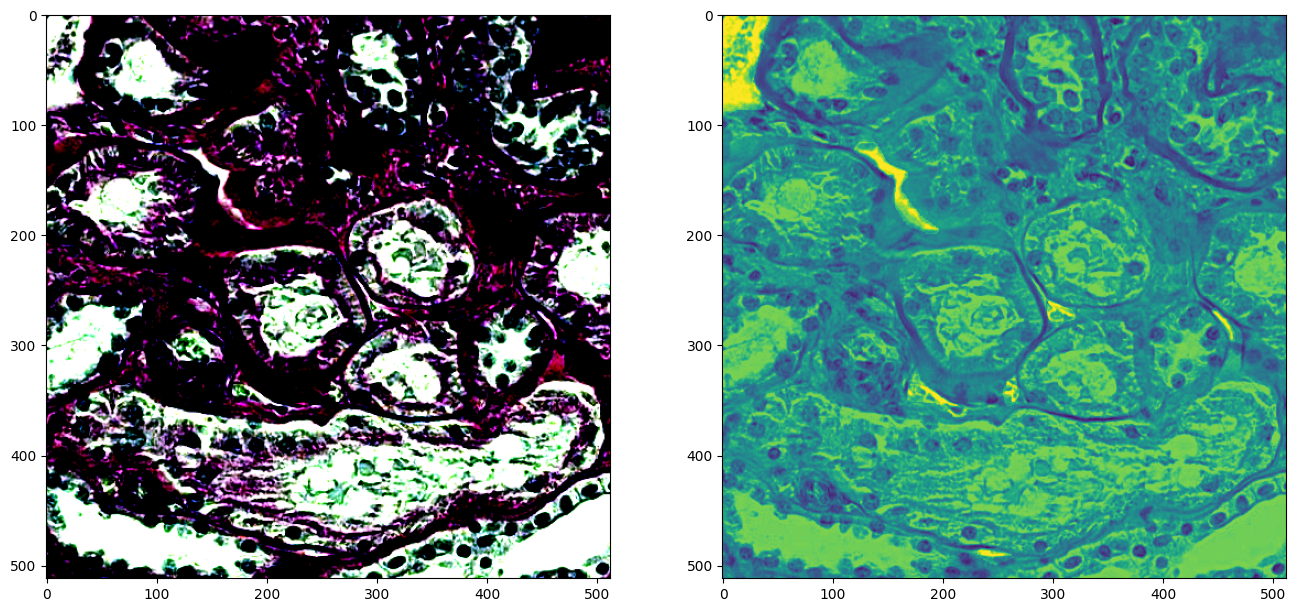

In [5]:
# visualize the data

indx = np.random.randint(0, len(train_dataset))
image, mask = train_dataset[indx]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(mask)


plt.subplot(1, 2, 2)
plt.imshow(0.5 * image.permute(1, 2, 0)[:, :, 0] + 0.6 * mask)


In [6]:
n_train = len(train_dataset)
n_val = len(val_dataset)


dataloader_train = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=1,
                              shuffle=True, pin_memory=False, drop_last=True)

dataloader_valid = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, num_workers=1,
                              shuffle=False, pin_memory=False, drop_last=False)


In [7]:
# get one batch from dataloader_train

for batch in dataloader_train:
    images, masks = batch
    break

In [8]:
import cv2
import numpy as np

def seg_to_det(
    seg: np.ndarray, 
    seg_thresh: float
):
    num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats((seg > seg_thresh).astype(np.uint8)*255, 8)
    boxes = stats[:, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]
    label_masks = [labels == i for i in range(num_outputs)]
    dets = {
        "boxes": np.stack([
            boxes[:, 0],
            boxes[:, 1],
            boxes[:, 0] + boxes[:, 2],
            boxes[:, 1] + boxes[:, 3],
        ], axis=1),
        "masks": [seg * m for m in label_masks],
    }
    dets["scores"] = [np.mean(seg[m]) for m in label_masks]
    
    # remove dets element where 'boxes' = [0, 0, 512, 512]
    boxes_to_remove = [0, 0, 512, 512]
    indices_to_remove = np.where(np.all(dets["boxes"] == boxes_to_remove, axis=1))
    
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    return dets


# Competition metric

In [9]:
pass

# FBeta metric

In [10]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=1.0, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

# Model

In [11]:
from transformers import SegformerForSemanticSegmentation
import torch

class Segformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=1,
                                                         ignore_mismatched_sizes=True,
                                                         num_channels=3)
        self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
    def forward(self, x):
        x = self.seg_model(x).logits
        x = self.up(x)
        return x



model = Segformer()

state_dict = torch.load("/home/viktor/Documents/kaggle/hubmap-2023/experiments/segformer-b5-autoencoder-all-data/ckpts/segformer_epoch_60.pt")
model.load_state_dict(state_dict)

model = model.to(CFG.device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.

In [12]:
x = torch.randn(1, 3, 512, 512).to(CFG.device)
with torch.no_grad():
    out = model(x)
out.shape

torch.Size([1, 1, 512, 512])

# Criterion

In [13]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
FocalLoss = smp.losses.FocalLoss(mode='binary')

def criterion(y_pred, y_true):
    
    
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    
    
    # return FocalLoss(y_pred, y_true)


In [14]:
# Set AdamW optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 
                                              start_factor=0.01,
                                              end_factor=1,
                                              total_iters=10)


# Training

In [15]:
best_fbeta_ = 0.0


for epoch in range(1, CFG.EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    
    mloss_train = 0.

    for i, (images, masks) in pbar_train:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        
        
        optimizer.zero_grad()
        pred_masks = model(images)
        loss = criterion(pred_masks.squeeze(), masks)
        loss.backward()
        mloss_train += loss.detach().item()
        optimizer.step()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
        # if i > 10:
        #     break
    
    
    out = {}
    out['epoch'] = epoch
    out['loss_train'] = mloss_train / len(dataloader_train)
    
    model.eval()
    
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    
    mloss_val = 0.
    
    
    best_th     = 0.0
    best_fbeta  = 0.0
    
    th_array = np.arange(0.01, 1.00, 0.01)
    
    y_true_count = 0
    ctp = {}
    cfp = {}
    for th in th_array:
        ctp[str(th)] = 0
        cfp[str(th)] = 0
    
    for i, (images, masks) in pbar_val:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        
        masks = masks.squeeze()
        with torch.no_grad():
            pred_masks = model(images)
            mloss_val += criterion(pred_masks.squeeze(), masks).item()
            pred_masks = torch.sigmoid(pred_masks)
            
        pred_masks = pred_masks.squeeze()
        y_true_count += masks.sum()
        
        for th in th_array:
            preds_t = torch.where(pred_masks > th, 1.0, 0.0).float()
            cfp[str(th)] += preds_t[masks==0].sum()
            ctp[str(th)] += preds_t[masks==1].sum()
        
        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    
    c_precision = {}
    c_recall = {}
    dice = {}
    
    for th in th_array:
        c_precision[str(th)] = ctp[str(th)] / (ctp[str(th)] + cfp[str(th)] + 1e-5)
        c_recall[str(th)] = ctp[str(th)] / (y_true_count + 1e-5)
        dice[str(th)] = (1 + 1) * (c_precision[str(th)] * c_recall[str(th)]) / (1 * c_precision[str(th)] + c_recall[str(th)] + 1e-5)
    
    
    # find the best threshold
    best_fbeta = 0
    for th in th_array:
        if dice[str(th)] > best_fbeta:
            best_fbeta = dice[str(th)].item()
            best_th = th
    
    
    scheduler.step()
    
    out['loss_val'] = mloss_val / len(dataloader_valid)
    out['th_best'] = best_th 
    out['best_fbeta'] = best_fbeta 
    
    
    # save out to csv. Rewrite every epoch
    if epoch == 1:
        df = pd.DataFrame(out, index=[0])
        df.to_csv("./segformer.csv", index=False)
    else:
        df = pd.DataFrame(out, index=[0])
        df_old = pd.read_csv("./segformer.csv")
        df = pd.concat([df_old, df], axis=0)
        df.to_csv("./segformer.csv", index=False)
    
    
    
    torch.save(model.state_dict(), f"./ckpts/segformer_epoch_{epoch}.pt")
    

  0%|          | 0/233 [00:00<?, ?it/s]

Epoch 1/100  Mem : 17.1GB  3.0000000000000004e-07  Loss: 0.8054: 100%|██████████| 233/233 [01:12<00:00,  3.20it/s]
Val Loss: 0.8069: 100%|██████████| 39/39 [00:07<00:00,  5.55it/s]
Epoch 2/100  Mem : 17.1GB    3.27e-06  Loss: 0.8039: 100%|██████████| 233/233 [01:13<00:00,  3.19it/s]
Val Loss: 0.8035: 100%|██████████| 39/39 [00:07<00:00,  5.55it/s]
Epoch 3/100  Mem : 17.1GB  6.2399999999999995e-06  Loss: 0.7641: 100%|██████████| 233/233 [01:12<00:00,  3.20it/s]
Val Loss: 0.7386: 100%|██████████| 39/39 [00:07<00:00,  5.53it/s]
Epoch 4/100  Mem : 17.1GB  9.209999999999998e-06  Loss: 0.6766: 100%|██████████| 233/233 [01:13<00:00,  3.17it/s]
Val Loss: 0.6368: 100%|██████████| 39/39 [00:06<00:00,  5.59it/s]
Epoch 5/100  Mem : 17.1GB  1.2179999999999999e-05  Loss: 0.6276: 100%|██████████| 233/233 [01:12<00:00,  3.20it/s]
Val Loss: 0.6002: 100%|██████████| 39/39 [00:07<00:00,  5.53it/s]
Epoch 6/100  Mem : 17.1GB  1.5149999999999999e-05  Loss: 0.6014:  59%|█████▉    | 138/233 [00:42<00:29,  3.2

KeyboardInterrupt: 